# Data Cleaning, Feature Selection and Engineering

**In this notebook, I apply data cleaning and feature selection techniques to the datasets to prepare them for modeling. In addition, I created some features that summarized a combination of features originally contained in the data.**


## Importing modules and clean data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('dark')

%matplotlib inline

data = '../data/housing_clean.csv'
test_data = '../data/test_clean.csv'
housing = pd.read_csv(data)
test = pd.read_csv(test_data)

## Outlier selection

Let's examine our strongly correlated variables since any outliers in those features will affect our models more signficantly:

### Overall quality

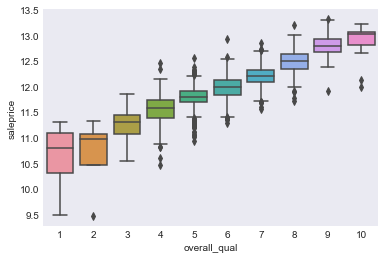

In [5]:
sns.boxplot(housing['overall_qual'], housing.saleprice)

We see that there are signficantly low outliers for price for houses with quality 2, 9, and 10. While outliers on the high end make sense in a positively linear relationship between quality and price, the low outliers probably have their prices reduced by some other factor. 

Let's look at the rows for those outliers and keep them in mind:

In [6]:
compare = ['saleprice', 'overall_qual']

In [7]:
housing[(housing['overall_qual'] == 2) & (housing['saleprice']< 10)][compare]

,saleprice,overall_qual
1628,9.456419,2


This gives us the $log$ saleprice for the quality 2 outlier. If we exponentiate it, we get an approximate value in dollars:

In [11]:
np.expm1(9.456419)

12789.001348412834

We see that this house sold for only $12800 (which seems quite low).

Let's look at the prices for the quality 9/10 outliers:

In [12]:
housing[((housing['overall_qual'] == 9) | (housing['overall_qual'] == 10)) & (housing['saleprice']< 12.3)][compare]

,saleprice,overall_qual
125,11.918397,9
960,11.982935,10
1885,12.121881,10


Let's exponentiate our saleprices for these three houses:

In [13]:
[np.expm1(x) for x in [11.91, 11.98, 12.12]]

[148745.67943014178, 159531.0306232254, 183504.51490438476]

These three homes sold for under $200,000.

In [12]:
np.expm1(housing[((housing['overall_qual'] == 9) | (housing['overall_qual'] == 10))].saleprice.mean())

369846.30266367417

Looking at the average sale price for condition 9 or 10 homes, the three homes listed above are well below the mean.

### Above ground living area

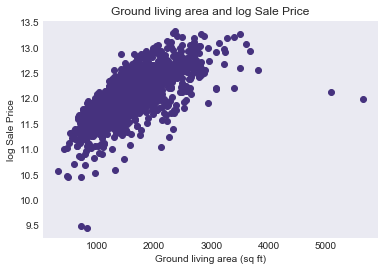

In [17]:
plt.scatter(housing['gr_liv_area'], housing.saleprice)
plt.title('Ground living area and log Sale Price')
plt.xlabel('Ground living area (sq ft)')
plt.ylabel('log Sale Price');

**We see that there are some noticeable outliers with high area but relatively low price and some with low area and extremely low price:**

In [18]:
housing[(housing['gr_liv_area'] > 5000) & (housing['saleprice'] < 12.5)]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,...,0,480,Gd,None,None,0,1,2008,New,11.982935
1885,2181,908154195,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,...,0,0,None,None,Elev,17000,10,2007,New,12.121881


**House ID 1499 and 2181 are our outliers. It is likely that these homes are on large lots closer to agricultural zones and thus have low values even though they represent large, high-quality properties. Let's drop these rows:**

In [19]:
housing.drop([960, 1885], axis=0, inplace=True)

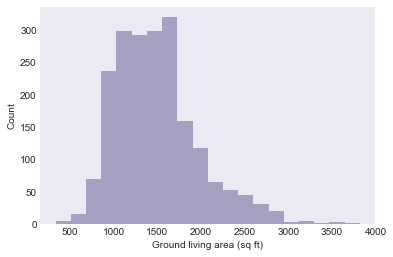

In [25]:
sns.distplot(housing.gr_liv_area, bins=20, kde=False)
plt.xlabel('Ground living area (sq ft)')
plt.ylabel('Count');

**Next, let's look at the homes with low area and very low price:**

In [21]:
housing[(housing['gr_liv_area'] < 1000) & (housing['saleprice'] < 10)]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
183,1554,910251050,20,A (agr),80.0,14584,Pave,Reg,Low,AllPub,...,0,0,None,None,None,0,2,2008,WD,9.480444
1628,182,902207130,30,RM,68.0,9656,Pave,Reg,Lvl,AllPub,...,0,0,None,None,None,0,6,2010,WD,9.456419


**Let's drop these observations as well.**

In [26]:
housing.drop([183, 1628], axis=0, inplace=True)

###  Lot area

Let's look at the distribution of this feature first:

Text(0.5,1,'Boxplot of lot area')

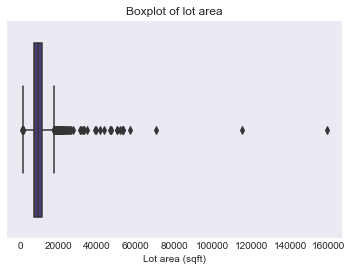

In [31]:
sns.boxplot(housing.lot_area)
plt.xlabel('Lot area (sqft)')
plt.title('Boxplot of lot area')

In [28]:
housing[housing.lot_area > 100000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
471,2116,906426060,50,RL,68.0,159000,Pave,IR2,Low,AllPub,...,0,0,None,None,Shed,500,6,2007,WD,12.531776
694,2072,905301050,20,RL,68.0,115149,Pave,IR2,Low,AllPub,...,0,0,None,None,None,0,6,2007,WD,12.618186


Let's drop the most extreme outliers (those with area > 100000 sqft)

In [32]:
housing.drop([471, 694], axis=0, inplace=True)

### Lot frontage

In [33]:
housing[(housing['lot_frontage'] > 200) & (housing['saleprice'] < 13)]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1335,1266,535427070,20,RL,313.0,27650,Pave,IR2,HLS,AllPub,...,0,0,None,None,None,0,11,2008,WD,12.396697


In [34]:
housing.drop(1335, axis=0, inplace=True)

## Feature Engineering

Let's make 2 features that summarize multiple columns:   
1) total_baths - The total number of bathrooms in the home  
2) total_outdoor - the total area of outdoor surrounded areas (decks and porches)

In [25]:
housing['total_baths'] = housing['bsmt_full_bath'] + 0.5*housing['bsmt_half_bath'] + \
housing['full_bath'] + 0.5*housing['half_bath']

In [27]:
housing['total_outdoor'] = housing['wood_deck_sf'] + housing['enclosed_porch'] + housing['3ssn_porch'] + housing['open_porch_sf'] \
+housing['screen_porch']

In [26]:
test['total_baths'] = test['bsmt_full_bath'] + 0.5*test['bsmt_half_bath'] + \
test['full_bath'] + 0.5*test['half_bath']

In [28]:
test['total_outdoor'] = test['wood_deck_sf'] + test['enclosed_porch'] + test['3ssn_porch'] + test['open_porch_sf'] \
+test['screen_porch']

Let's drop the individual parts now:

In [29]:
bath_vars = ['total_baths', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath']
outdoor_var = ['wood_deck_sf', 'enclosed_porch', '3ssn_porch', 'open_porch_sf', 'screen_porch']

housing.drop(bath_vars + outdoor_var, axis=1, inplace=True)
test.drop(bath_vars + outdoor_var, axis=1, inplace=True)

Since we already have a total basement size column, let's remove the individual components of that variable as well:

In [30]:
bsmt_vars = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'low_qual_fin_sf']

housing.drop(bsmt_vars, axis=1, inplace=True)
test.drop(bsmt_vars, axis=1, inplace=True)

### Dropping/redefining columns with low counts

In [32]:
housing.kitchen_abvgr.value_counts()

1    1952
2      88
0       2
3       1
Name: kitchen_abvgr, dtype: int64

A large majority of the homes have 1 kitchen above ground. Let's drop this column.

In [33]:
housing.drop('kitchen_abvgr', axis=1, inplace=True)
test.drop('kitchen_abvgr', axis=1, inplace=True)

In [34]:
housing.fireplaces.value_counts()

0    999
1    896
2    142
3      5
4      1
Name: fireplaces, dtype: int64

Most houses have either 1 or no fireplace. Let's define the column to just show whether or not the house had a fireplace:

In [35]:
housing['fireplaces'] = housing['fireplaces'].map({0: 0, 1:1, 2:1, 3:1, 4:1})

In [36]:
housing.fireplaces.value_counts()

1    1044
0     999
Name: fireplaces, dtype: int64

In [37]:
housing.street.value_counts()

Pave    2036
Grvl       7
Name: street, dtype: int64

Only 7 homes have access to a gravel road. Let's drop this column.

In [38]:
housing.drop('street', axis=1, inplace=True)
test.drop('street', axis=1, inplace=True)

Less than 10 homes have pools. Let's drop the columns related to pools:

In [39]:
housing.drop(['pool_area', 'pool_qc'], axis=1, inplace=True)

In [40]:
test.drop(['pool_area', 'pool_qc'], axis=1, inplace=True)

While `utilities` has 3 classes, all but 1 observation were in the AllPub class:

In [41]:
housing['utilities'].value_counts()

AllPub    2041
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64

In [42]:
housing.drop('utilities', axis=1, inplace=True)
test.drop('utilities', axis=1, inplace=True)

Most of the homes don't have an additional miscellaneous feature:

In [43]:
housing.misc_feature.value_counts()

None    1980
Shed      55
Gar2       4
Othr       3
TenC       1
Name: misc_feature, dtype: int64

Let's drop this column and the corresponding `misc_val`:

In [44]:
housing.drop(['misc_feature', 'misc_val'], axis=1, inplace=True)

test.drop(['misc_feature', 'misc_val'], axis=1, inplace=True)

In [45]:
housing.drop('fence', axis=1, inplace=True)

In [46]:
test.drop('fence', axis=1, inplace=True)

## Converting numeric variables to categorical

I identified the numeric and categorical variables based on the output of the `plotting` function. We can see that some features are encoded as numeric but represent categories. 

In [47]:
catcols = ['ms_subclass', 'mo_sold', 'yr_sold', 'bedroom_abvgr','fireplaces']

Then we convert the numeric variables contained in `catcols` into categorical ones:

In [48]:
housing[catcols] = housing[catcols].astype(str)

test[catcols] = test[catcols].astype(str)

## Deskewing features

It would make sense for some of the numeric features to be skewed (there's a lower bound on many features required in a house, but the upper bound would only be constrained by the desires and resources of the land owner). Let's examine the skew of the numeric features:

In [49]:
numerics = [x for x in housing.select_dtypes(exclude='object').columns if x not in ['id', 'pid', 'saleprice']]

In [50]:
for x in housing[numerics].columns:
    print('The skew for', x, 'is', stats.skew(housing[x]))

The skew for lot_frontage is 0.6835436835015811
The skew for lot_area is 3.557661992006577
The skew for overall_qual is 0.1677345946748799
The skew for overall_cond is 0.6535585438381812
The skew for year_built is -0.609427873960729
The skew for year_remod/add is -0.45001246929552496
The skew for mas_vnr_area is 2.5762448569716763
The skew for total_bsmt_sf is 0.4328170103730551
The skew for 1st_flr_sf is 0.9657594309207403
The skew for 2nd_flr_sf is 0.8725058847799948
The skew for gr_liv_area is 0.92937370047083
The skew for totrms_abvgrd is 0.7781725280906366
The skew for garage_cars is -0.22633028810730083
The skew for garage_area is 0.15682120182705503
The skew for total_outdoor is 1.3556398559658032


Let's log transform features with skew > 0.8 to make them closer to normal:

In [51]:
for x in housing[numerics].columns:
    if stats.skew(housing[x]) > .8:
        housing[x] = np.log1p(housing[x])
    else:
        housing[x]

In [52]:
for x in housing[numerics].columns:
    print('The skew for', x, 'is', stats.skew(housing[x]))

The skew for lot_frontage is 0.6835436835015811
The skew for lot_area is -0.8359352582410123
The skew for overall_qual is 0.1677345946748799
The skew for overall_cond is 0.6535585438381812
The skew for year_built is -0.609427873960729
The skew for year_remod/add is -0.45001246929552496
The skew for mas_vnr_area is 0.5432219221516017
The skew for total_bsmt_sf is 0.4328170103730551
The skew for 1st_flr_sf is -0.049552426722091
The skew for 2nd_flr_sf is 0.33946042114433894
The skew for gr_liv_area is -0.05309126712996394
The skew for totrms_abvgrd is 0.7781725280906366
The skew for garage_cars is -0.22633028810730083
The skew for garage_area is 0.15682120182705503
The skew for total_outdoor is -1.3547786780766724


Let's look closer at some of the skewed variables:

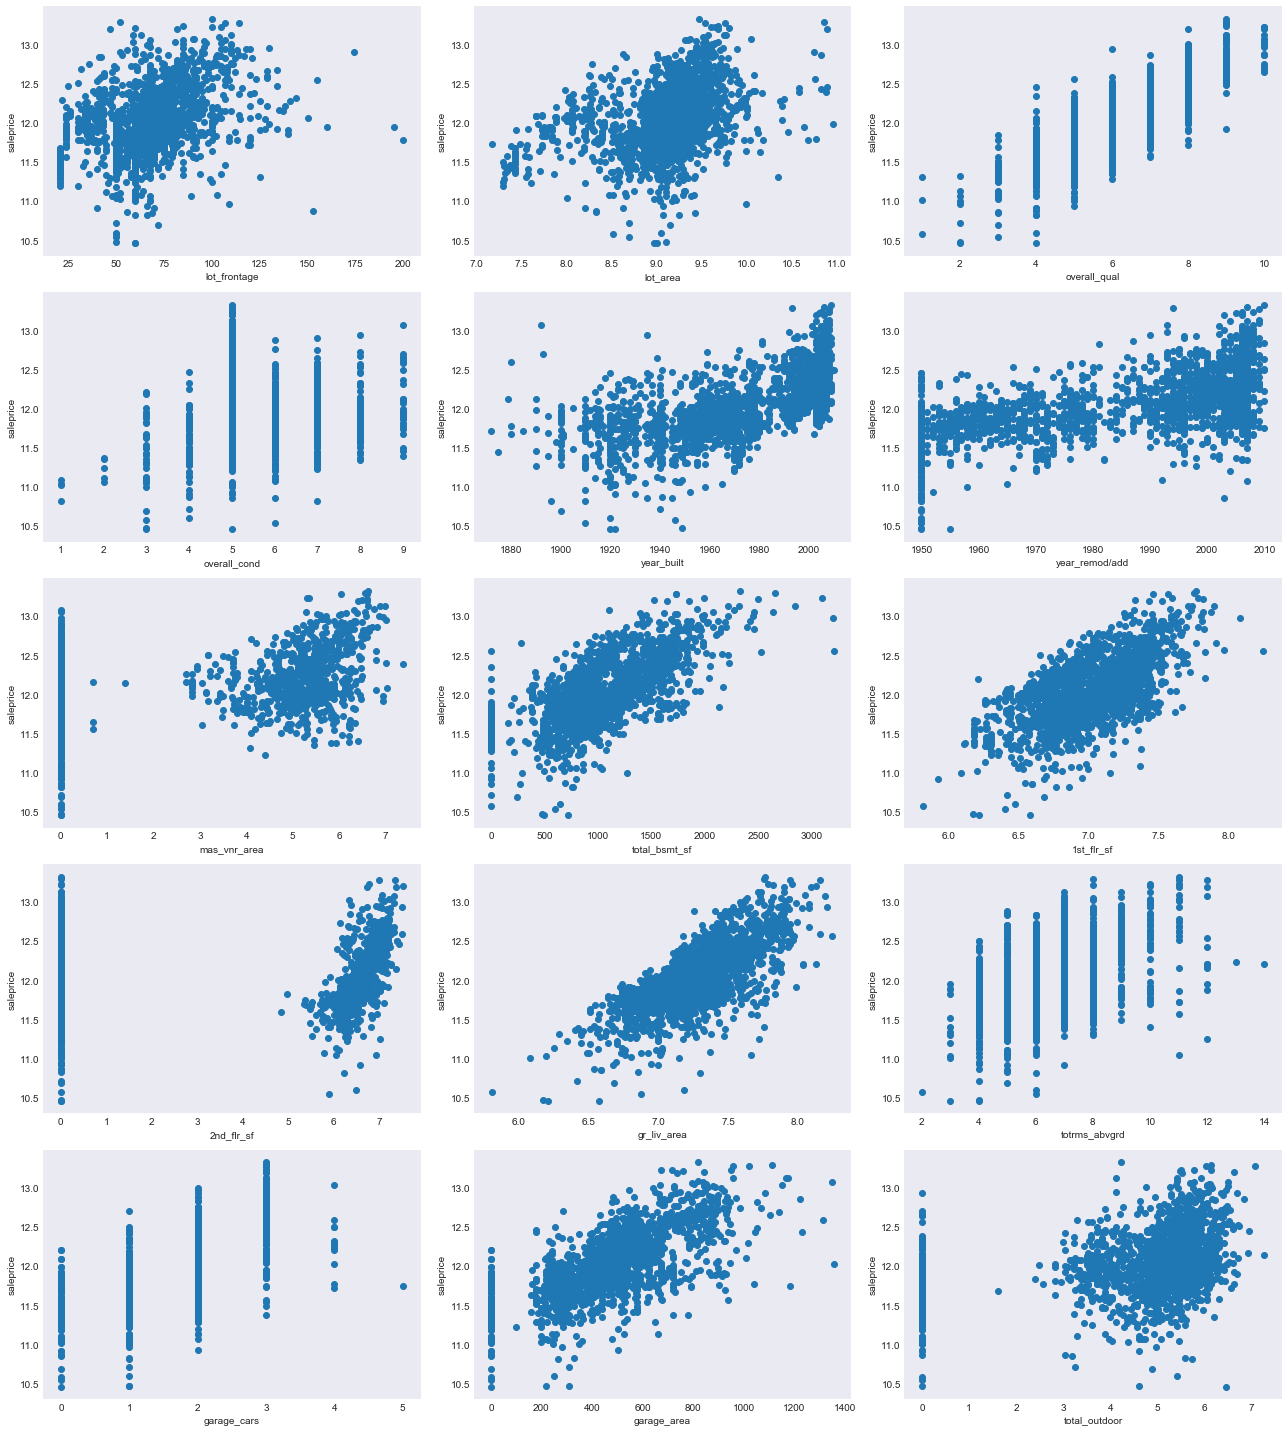

In [53]:
plotting(housing, housing[numerics].columns , 'saleprice', 3)

Some of these variables are skewed because of a presence of two modes (one for those with the feature and 0 for homes without the feature). Let's convert the variables with this nature to be 1/0 categorical or drop them in favor of continuous ones:

In [54]:
housing['has_masonry'] = np.where(housing['mas_vnr_area'] != 0 , 1, 0)
housing['has_2nd_flr'] = np.where(housing['2nd_flr_sf'] !=0, 1, 0)
housing['has_garage'] = np.where(housing['garage_cars'] !=0, 1, 0)
housing['has_outdoor'] = np.where(housing['total_outdoor'] !=0, 1, 0)

test['has_masonry'] = np.where(test['mas_vnr_area'] != 0 , 1, 0)
test['has_2nd_flr'] = np.where(test['2nd_flr_sf'] !=0, 1, 0)
test['has_garage'] = np.where(test['garage_cars'] !=0, 1, 0)
test['has_outdoor'] = np.where(test['total_outdoor'] !=0, 1, 0)

In [55]:
housing.drop('total_outdoor', axis=1, inplace=True)
test.drop('total_outdoor', axis=1, inplace=True)

In [56]:
garage_vars = [x for x in housing.columns if 'gar' in x]

garage_vars.remove('has_garage')

housing.drop(garage_vars, axis=1, inplace=True)
test.drop(garage_vars, axis=1, inplace=True)

In [57]:
housing.drop(columns=['mas_vnr_type', 'mas_vnr_area'], axis=1, inplace=True)
test.drop(columns=['mas_vnr_type', 'mas_vnr_area'], axis=1, inplace=True)

In [58]:
housing.drop('2nd_flr_sf', axis=1, inplace=True)
test.drop('2nd_flr_sf', axis=1, inplace=True)

Since lot frontage and lot area are be highly correlated, let's drop lot frontage as it encodes less information.

In [59]:
housing.drop('lot_frontage', axis=1, inplace=True)
test.drop('lot_frontage', axis=1, inplace=True)

## Generate dummy variables

First, we generate a list of columns that are non-numeric (including those we converted above) and assign them to the variable `to_be_dummies`:

In [60]:
to_be_dummies = housing.select_dtypes(include='object').columns

In [61]:
len(to_be_dummies)

36

Then we create dummies for those columns:

In [62]:
housing = pd.get_dummies(housing, columns=to_be_dummies)

Now let's do the same with the test set to prepare it for modeling:

In [63]:
test[catcols] = test[catcols].astype(str)

test_dummies = test.select_dtypes(include='object').columns

test = pd.get_dummies(test, columns=test_dummies)

### Checking shape of datasets

In [64]:
housing.shape, test.shape

((2043, 274), (879, 261))

We can see that there are several dummy categories that didn't show up in the test set (since the number of columns in the training data exceeds that number in the test data). Let's examine the value counts of those variables:

In [65]:
not_in_test = set(housing.columns)^set(test.columns)

only_in_test = []

for i in not_in_test:
    try:
        housing[i].value_counts()
    except:
        only_in_test.append(i)

Based on the above output, we see that many of the categories have very low value counts (<10). Let's remove those categories (in addition to those dummies that are in the test data but not in the train data): 

In [66]:
dummies_to_drop = [x for x in not_in_test if x not in ['overall_qual_10', 'saleprice', 'ms_zoning_C', 'garage_qual_Fa',\
                                                       'bsmt_cond_Fa'] + only_in_test]

housing.drop(axis=1, columns=dummies_to_drop, inplace=True)

test.drop(axis=1, columns=only_in_test, inplace=True)

In [67]:
in_train = list(set(housing.columns)-set(test.columns))

in_train.remove('saleprice')

for col in in_train:
    test[col] = 0

no_target = [x for x in housing.columns if x != 'saleprice']

test = test[housing[no_target].columns]

In [68]:
housing.shape

(2043, 252)

## Exporting for modeling

Now we export these data to use in the modeling worksheet:

In [69]:
housing.to_csv('../data/train_model_ready.csv', index=False)
test.to_csv('../data/test_model_ready.csv', index=False)

In [70]:
housing.shape, test.shape

((2043, 252), (879, 251))